# Data Preparation
-----

### Constants and Folder Paths

In [85]:
dataset_folder_path = 'temp'
NUM_SAMPLES = 200

### Load Data and Split into *Test*, *Train/Valid*

In [113]:
from data.DataSet import DataSet
dataset = DataSet()
dataset.load(dataset_folder_path, test_set_percentage=0.5)

In [114]:
len(dataset.train_data)

1800

In [115]:
len(dataset.test_data)

1800

### Data Preprocessing

In [116]:
from utils.preprocessing import *
from functools import partial
dataset.apply(apply_mean_centering)
dataset.apply(apply_unit_distance_normalization)
#dataset.apply(partial(normalize_pressure_value, max_pressure_val=512))
dataset.apply(partial(spline_interpolate_and_resample, num_samples=NUM_SAMPLES))
dataset.expand(reverse_digit_sequence)
# dataset.apply(lambda digit: convert_xy_to_derivative(digit, normalize=False))
#dataset.apply(partial(convert_xy_to_derivative, normalize=True))

### Split Dataset into *Train*, *Valid*, and *Test*

In [117]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train_valid = np.array(dataset.train_data)
X_test = np.array(dataset.test_data)
# Convert labels to numpy array and OneHot encode them
encoder, train_valid_labels, Y_test = dataset.get_labels_as_numpy(onehot=True)
train_valid_labels = train_valid_labels.astype('float32').todense()
Y_test = Y_test.astype('float32').todense()
# Split Data
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train_valid, train_valid_labels, shuffle=True, stratify=train_valid_labels, random_state=42)

----------
# Neural Network Setup and Training
----------

## **Regularized Naive GRU**

### Parameters

In [89]:
PARAM_NUM_EPOCHS = 30
PARAM_BATCH_SIZE = 300

### Setup Model

In [90]:
from models.regularized_gru import NaiveRegularizedGRU

mymodel = NaiveRegularizedGRU(X_train.shape[1:])
mymodel.batch_size = PARAM_BATCH_SIZE
mymodel.num_epochs = PARAM_NUM_EPOCHS
mymodel.initialize()
print(mymodel)



----------

Optimizer: <class 'keras.optimizers.Nadam'>
Batch Size: 300
Number of Epochs: 30

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_11 (GRU)                 (None, 200, 256)          198912    
_________________________________________________________________
dropout_11 (Dropout)         (None, 200, 256)          0         
_________________________________________________________________
gru_12 (GRU)                 (None, 256)               393984    
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                2570      
_________________________________________________________________
activation_6 (Activation)    (None, 10)                0         
Total params: 595,466
Trainable params: 595,46

#### Save Model Summary

In [91]:
mymodel.save_summary(dataset.get_recorded_operations())
mymodel.save_config()

### Train Model

In [92]:
mymodel.train(X_train, Y_train, X_valid, Y_valid)

Train on 2700 samples, validate on 900 samples
Epoch 1/30
2700/2700 [==============================] - 3s 1ms/step - loss: 2.1719 - categorical_accuracy: 0.1907 - val_loss: 2.1087 - val_categorical_accuracy: 0.2333

Epoch 00001: val_categorical_accuracy improved from -inf to 0.23333, saving model to checkpoints/1524405313.503832/naive_regularized_gru-01-0.23.hdf5
Epoch 2/30
2700/2700 [==============================] - 3s 1ms/step - loss: 2.1120 - categorical_accuracy: 0.2030 - val_loss: 2.1116 - val_categorical_accuracy: 0.1911

Epoch 00002: val_categorical_accuracy did not improve
Epoch 3/30
2700/2700 [==============================] - 3s 1ms/step - loss: 2.0536 - categorical_accuracy: 0.2074 - val_loss: 1.9502 - val_categorical_accuracy: 0.2900

Epoch 00003: val_categorical_accuracy improved from 0.23333 to 0.29000, saving model to checkpoints/1524405313.503832/naive_regularized_gru-03-0.29.hdf5
Epoch 4/30
2700/2700 [==============================] - 3s 1ms/step - loss: 1.9414 - cate

### Evaluate Model

#### Test Set Accuracy

In [93]:
test_score = tuple(mymodel.model.evaluate(X_test, Y_test))
print("Test Loss: %.3f, Test Acc: %.3f%%" % (test_score[0], test_score[1] * 100))

3600/3600 [==============================] - 6s 2ms/step
Test Loss: 0.326, Test Acc: 92.083%


#### Recall, Precision, F1_Score on Validation set

In [94]:
from utils.evaluation import get_evaluation_metrics, get_confusion_matrix

Y_predicted_valid = mymodel.model.predict_classes(X_valid, verbose=1)
rpf_valid = get_evaluation_metrics(Y_valid, Y_predicted_valid)
rpf_valid

900/900 [==============================] - 2s 2ms/step


,recall,precision,f1 score,#
0,0.978261,1.000000,0.989011,90.0
1,0.976744,0.933333,0.954545,90.0
2,0.977778,0.977778,0.977778,90.0
3,0.988889,0.988889,0.988889,90.0
4,0.937500,1.000000,0.967742,90.0
5,0.978261,1.000000,0.989011,90.0
6,1.000000,0.988889,0.994413,90.0
7,1.000000,0.966667,0.983051,90.0
8,0.988764,0.977778,0.983240,90.0
9,0.988764,0.977778,0.983240,90.0


Average F1 Score for Validation Set

In [95]:
rpf_valid.mean()

recall        0.981496
precision     0.981111
f1 score      0.981092
#            90.000000
dtype: float64

#### Recall, Precision, F1_Score on Test set

In [96]:
from utils.evaluation import get_evaluation_metrics, get_confusion_matrix

Y_predicted_test = mymodel.model.predict_classes(X_test, verbose=1)
rpf_test = get_evaluation_metrics(Y_test, Y_predicted_test)
rpf_test

3600/3600 [==============================] - 6s 2ms/step


,recall,precision,f1 score,#
0,0.966574,0.963889,0.965229,360.0
1,0.882952,0.963889,0.921647,360.0
2,0.863524,0.966667,0.912189,360.0
3,0.982759,0.950000,0.966102,360.0
4,0.935310,0.963889,0.949384,360.0
5,0.891892,0.916667,0.904110,360.0
6,0.985673,0.955556,0.970381,360.0
7,0.965779,0.705556,0.815409,360.0
8,0.921283,0.877778,0.899004,360.0
9,0.847880,0.944444,0.893561,360.0


Average F1 Score for Test Set

In [97]:
rpf_test.mean()

recall         0.924363
precision      0.920833
f1 score       0.919702
#            360.000000
dtype: float64

##### Increase default plotsize for matplotlib

In [98]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

#### Plot Validation Set Confusion Matrix

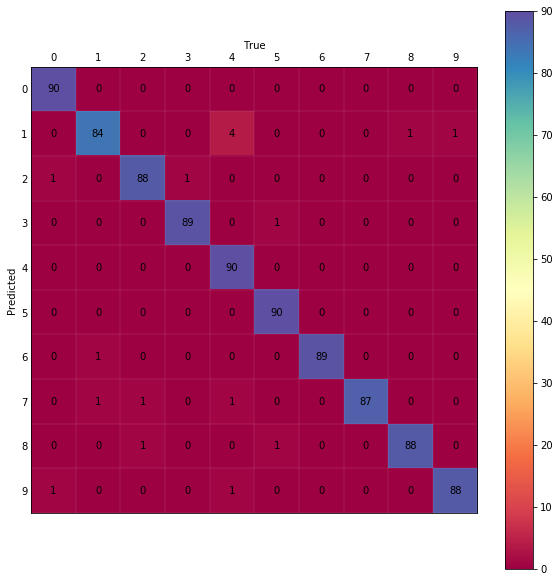

In [99]:
from utils.evaluation import get_confusion_matrix
# Confusion Matrix
confmat = get_confusion_matrix(Y_valid, Y_predicted_valid, plot=True)

#### Plot Test Set Confusion Matrix

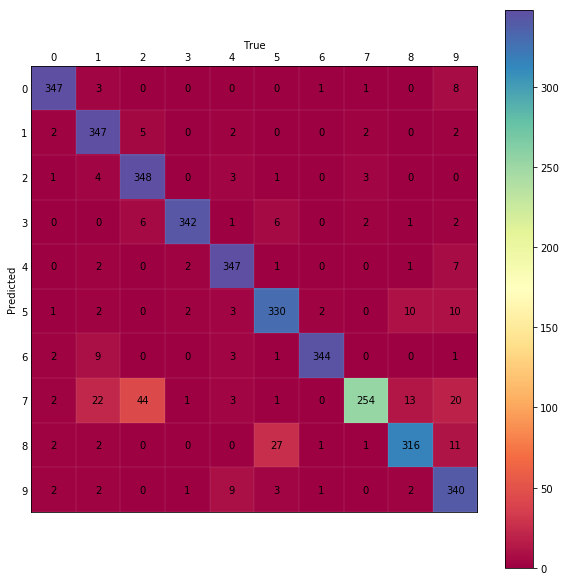

In [100]:
from utils.evaluation import get_confusion_matrix
# Confusion Matrix
confmat = get_confusion_matrix(Y_test, Y_predicted_test, plot=True)

# Backup Code
-----

In [11]:
from keras.models import load_model
mymodel.model = load_model("checkpoints/1523369406.7123575/naive_overfit_gru-30-0.97.hdf5")